Install System Requirements

In [ ]:
!pip install qiskit-machine-learning
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer
!pip install genomic-benchmarks

from IPython.display import clear_output
clear_output()

Data Preprocessing

<>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-2-8c9b8448056a>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
  label = 'Malignant' if k is 1 else 'Benign'


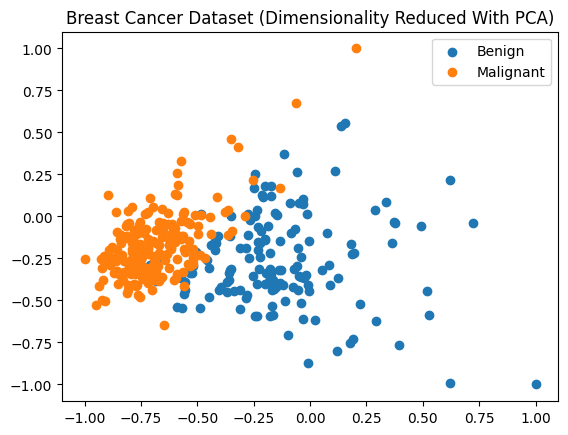

Training data shape: (349, 2)
Testing data shape: (49, 2)


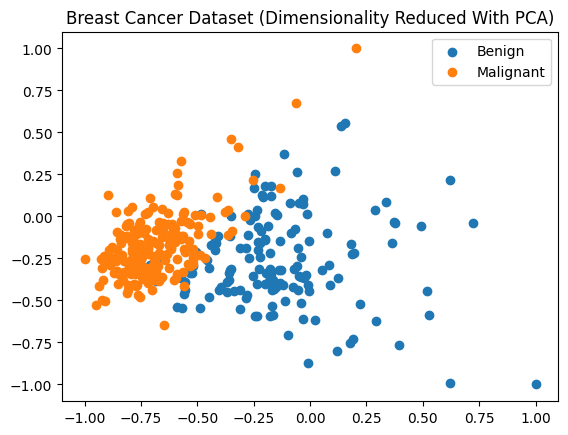

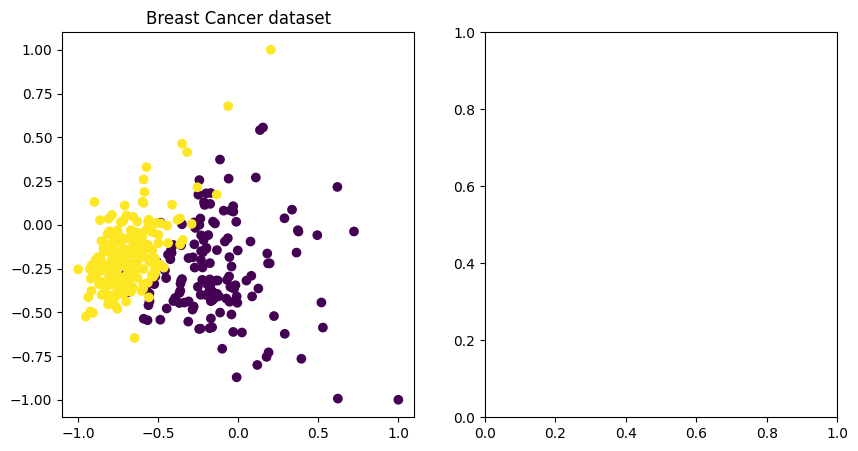

In [ ]:
import numpy as np
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


def breast_cancer(training_size, test_size, n, PLOT_DATA=True):
    class_labels = [r'Benign', r'Malignant']

    # First the dataset must be imported.
    cancer = datasets.load_breast_cancer()

    # To find if the classifier is accurate, a common strategy is
    # to divide the dataset into a training set and a test set.
    # Here the data is divided into 70% training, 30% testing.
    X_train, X_test, Y_train, Y_test = train_test_split(cancer.data, cancer.target, test_size=0.3, random_state=109)

    # Now the dataset's features will be standardized
    # to fit a normal distribution.
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # To be able to use this data with the given
    # number of qubits, the data must be broken down from
    # 30 dimensions to `n` dimensions.
    # This is done with Principal Component Analysis (PCA),
    # which finds patterns while keeping variation.
    pca = PCA(n_components=n).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    # The last step in the data processing is
    # to scale the data to be between -1 and 1
    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)

    # Now some sample should be picked to train the model from
    training_input = {key: (X_train[Y_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (X_train[Y_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 2):
            x_axis_data = X_train[Y_train == k, 0][:training_size]
            y_axis_data = X_train[Y_train == k, 1][:training_size]

            label = 'Malignant' if k is 1 else 'Benign'
            plt.scatter(x_axis_data, y_axis_data, label=label)

        plt.title("Breast Cancer Dataset (Dimensionality Reduced With PCA)")
        plt.legend()
        plt.show()


    return X_train, training_input, test_input, class_labels

def split_dataset_to_data_and_labels(input_data):
    data = []
    labels = []
    for label, features in input_data.items():
        data.append(features)
        # Convert labels to 0 and 1
        if label == 'Benign':
            labels.append([0] * len(features))
        else:
            labels.append([1] * len(features))
    return np.vstack(data), np.hstack(labels)

# Set parameters
n = 2  # Number of principal components
training_dataset_size = 200
testing_dataset_size = 100

# Get the dataset and split it
sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

# Split dataset into data and labels
data_train, train_labels = split_dataset_to_data_and_labels(training_input)
data_test, test_labels = split_dataset_to_data_and_labels(test_input)

# Print shapes to verify
print(f"Training data shape: {data_train.shape}")
print(f"Testing data shape: {data_test.shape}")


sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

data_train, data_train_labels = split_dataset_to_data_and_labels(training_input)
data_test, data_test_labels = split_dataset_to_data_and_labels(test_input)


fig,ax=plt.subplots(1,2,figsize=(10,5))

# Access the data directly from data_train using slicing
ax[0].scatter(data_train[:,0],data_train[:,1],c=data_train_labels) # Use data_train_labels for color coding
ax[0].set_title('Breast Cancer dataset');

QSVC

In [ ]:

from qiskit.circuit.library import ZZFeatureMap,PauliFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
#from qiskit_machine_learning.kernels import FidelityQuantumKernel,QuantumKernel
from qiskit_machine_learning.kernels import FidelityQuantumKernel

#from qiskit import BasicAer#
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 12345
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.algorithms import VQC
#from qiskit_machine_learning.datasets import iris
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.algorithms import QSVC
# Variables to track objective function and learning rate
objective_func_vals = []
learning_rates = []
perturbations = []
initial_learning_rate = 0.15  # Starting learning rate
initial_perturbation = 0.15  # Starting perturbation value
momentum = 0.95  # Momentum factor for smoother learning rate adjustments
gradient_moving_avg = 0  # Moving average of gradients


# Define quantum feature map and ansatz
feature_dim = data_train.shape[1]
prep = ZZFeatureMap(feature_dim, reps=2)

import matplotlib.pyplot as plt
import numpy as np

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
print(feature_map.num_qubits)

qsvc=QSVC(quantum_kernel=kernel)
#t0=time()
qsvc.fit(data_train, data_train_labels)
qsvc_score_test=qsvc.score(data_test, data_test_labels )
print(f"QSVC classification test score: {qsvc_score_test}")
#print(f"Time taken :{t1-t0}")

In [ ]:

qsvc_score_train=qsvc.score(data_train, data_train_labels )
print(f"QSVC classification train score: {qsvc_score_train}")

QSVC classification train score: 0.8796561604584527


DQSVC

Feature Dimention: 2


<ipython-input-10-64105059e891>:33: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


Iteration 1/10
Cost at iteration 1: -3.3194498234737235
Gradient norm at iteration 1: 98.74220111464517
Alpha update norm at iteration 1: 0.314913426707652
Phi update norm at iteration 1: 1.3023716257819111
QSVC accuracy at iteration 1: 0.975
Phis at iteration 1: [-0.27344633  0.05747879 -0.07661954 -0.10469647 -0.07027397  0.00117313
 -0.0598058  -0.12911814 -0.11137013  0.09013351  0.02093792 -0.03618114
 -0.0695179  -0.2258609  -0.17017911 -0.13205238 -0.07324719 -0.1392063
 -0.04682808 -0.07464324  0.03855038 -0.18590636 -0.082492    0.13549537
 -0.07034433 -0.0792171  -0.1487785   0.01239057 -0.09903175 -0.14006539
 -0.19715118 -0.11219323 -0.16285015 -0.16600856 -0.27074431 -0.28611381
 -0.00838581 -0.20077915 -0.08746287 -0.0625463  -0.09139579 -0.19794027
 -0.10242568 -0.07431426 -0.1458151  -0.11966878 -0.07558536  0.02876154
 -0.04668369 -0.17550896 -0.09732736 -0.16538675 -0.25311992 -0.12449601
 -0.23788637 -0.07220603 -0.1397101  -0.12021422 -0.07335378 -0.15464846
 -0.108

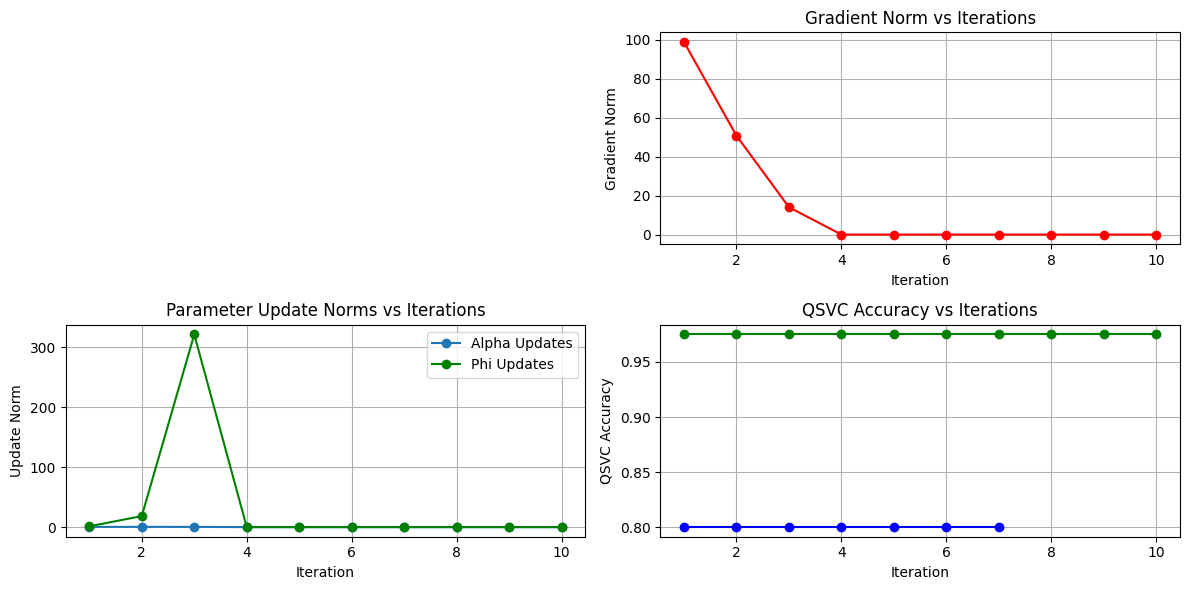

"\n\nfrom qiskit import Aer\nfrom qiskit.primitives import Sampler\n\n# Specify the backend explicitly (if needed)\nbackend = Aer.get_backend('qasm_simulator')\n\n# Create the sampler with the specified backend\nsampler = Sampler(backend=backend)\n"

In [ ]:
# Necessary imports
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_algorithms.utils import algorithm_globals
import csv  # Import CSV for saving results

#data_train, data_test, data_train_labels, data_test,data_test_labels

# Set random seed for reproducibility
seed = 1376
algorithm_globals.random_seed = seed

# Split dataset into training and test sets
#X, Y = features, labels
#train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.1, random_state=seed)

# Quantum feature map
feature_dim =data_train.shape[1] #
print(f"Feature Dimention: {feature_dim}")
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")

# Quantum kernel setup
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

# Initialize QSVC
qsvc = QSVC(quantum_kernel=kernel)

# Define deep unfolding parameters
T = 10  # Number of unfolding iterations
C = 1.0  # Regularization parameter
eta = 0.01  # Learning rate
eta_phi = 0.01  # Learning rate for phis
alphas = np.zeros(data_train_labels.shape)  # Initialize alpha coefficients
phis = np.random.randn(data_train_labels.shape[0])  # Initialize unfolding parameters

# Define the cost function gradient with respect to alphas
def compute_gradient(alphas, kernel_matrix, labels):
    grad = np.zeros_like(alphas)
    for i in range(len(alphas)):
        for j in range(len(alphas)):
            grad[i] += alphas[i] * alphas[j] * labels[i] * labels[j] * kernel_matrix[i, j]
    return grad - np.sum(alphas)

# Define the update rule for alphas based on deep unfolding
def update_alphas(alphas, grad, phis, eta):
    # Alphas update modulated by phis
    return alphas - eta * grad * np.tanh(phis)  # Phis influence the alpha update step

# Construct the quantum kernel matrix
kernel_matrix = kernel.evaluate(data_train)

# Initialize alphas and phis with small random values
alphas = np.random.rand(data_train_labels.shape[0]) * 0.1  # Small random initialization for alphas
phis = np.random.randn(data_train_labels.shape[0]) * 0.1  # Small random initialization for phis

# Define the cost function
def compute_cost(alphas, kernel_matrix, labels):
    cost = 0.5 * np.sum([
        alphas[i] * alphas[j] * labels[i] * labels[j] * kernel_matrix[i, j]
        for i in range(len(alphas)) for j in range(len(alphas))
    ]) - np.sum(alphas)
    return cost

# Define the gradient of cost with respect to phis
def compute_gradient_wrt_phi(grad_alpha, phis):
    # Placeholder: Approximate influence of phis on the alpha update step
    return np.dot(grad_alpha, phis)  # Simplified dependency

# Create a .csv file to save the results
csv_file = "deep_unfolding_qsvc_results_genomic.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the headers for each column
    writer.writerow(["Iteration", "Cost", "Gradient Norm", "Alpha Update Norm", "Phi Update Norm", "QSVC Accuracy", "Phis"])


# Add lists to track the gradient norms, parameter update norms, and classification accuracy
grad_norms = []
alpha_update_norms = []
phi_update_norms = []
accuracies = []

# Track costs for visualization
costs = []

# Initialize previous values of alphas and phis for tracking updates
previous_alphas = np.copy(alphas)
previous_phis = np.copy(phis)

# Deep unfolding optimization loop with updates and learning rate adjustment
for t in range(T):
    print(f"Iteration {t+1}/{T}")

    # Compute the gradient of the cost function with respect to alphas
    grad_alpha = compute_gradient(alphas, kernel_matrix, data_train_labels)

    # Compute gradient norm
    grad_norm = np.linalg.norm(grad_alpha)
    grad_norms.append(grad_norm)

    # Update alphas using deep unfolding rule where phis modulate the update step
    alphas = update_alphas(alphas, grad_alpha, phis, eta)

    # Ensure constraints are met: 0 <= alpha_i <= C
    alphas = np.clip(alphas, 0, C)

    # Ensure sum(alpha_i * y_i) = 0 constraint (more robust adjustment)
    alpha_sum = np.dot(alphas, data_train_labels)
    alphas -= alpha_sum / len(alphas)

    # Compute the gradient of the cost function with respect to phis
    grad_phi = compute_gradient_wrt_phi(grad_alpha, phis)

    # Update phis based on the gradient of the cost
    phis -= eta_phi * grad_phi

    # Compute parameter update norms
    alpha_update_norm = np.linalg.norm(alphas - previous_alphas)
    phi_update_norm = np.linalg.norm(phis - previous_phis)
    alpha_update_norms.append(alpha_update_norm)
    phi_update_norms.append(phi_update_norm)

    # Store the current values of alphas and phis for the next iteration
    previous_alphas = np.copy(alphas)
    previous_phis = np.copy(phis)

    # Compute and store the cost for this iteration
    cost = compute_cost(alphas, kernel_matrix, data_train_labels)
    costs.append(cost)

    # Adjust the learning rate dynamically based on gradient norms (deep unfolding principle)
    eta = max(0.0001, eta + 0.001 * np.linalg.norm(grad_alpha))  # Adjust eta dynamically
    eta_phi = max(0.0001, eta_phi + 0.001 * np.linalg.norm(grad_phi))  # Adjust eta_phi dynamically

    # After the current iteration, fit the QSVC model and evaluate its accuracy
    qsvc.fit(data_train, data_train_labels)
    accuracy = qsvc.score(data_test,data_test_labels)
    accuracies.append(accuracy)

    # Save the results to the .csv file after each iteration
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([t+1, cost, grad_norm, alpha_update_norm, phi_update_norm, accuracy, phis])


    print(f"Cost at iteration {t+1}: {cost}")
    print(f"Gradient norm at iteration {t+1}: {grad_norm}")
    print(f"Alpha update norm at iteration {t+1}: {alpha_update_norm}")
    print(f"Phi update norm at iteration {t+1}: {phi_update_norm}")
    print(f"QSVC accuracy at iteration {t+1}: {accuracy}")
    print(f"Phis at iteration {t+1}: {phis}")

# After deep unfolding, use the final alphas to train the QSVC model
qsvc.fit(data_train, data_train_labels)

# Evaluate QSVC
dqsvc_score_test = qsvc.score(data_test,data_test_labels)
print(f"DSVC classification test score after deep unfolding: {dqsvc_score_test}")

dqsvc_score_train = qsvc.score(data_train, data_train_labels)
print(f"DQSVC classification test score after deep unfolding: {dqsvc_score_train}")

# Plotting the cost values over the iterations
plt.figure(figsize=(12, 6))

# Plot gradient norm over iterations
plt.subplot(2, 2, 2)
plt.plot(range(1, len(grad_norms) + 1), grad_norms, marker='o', color='r')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm vs Iterations')
plt.grid(True)

# Plot alpha and phi update norms over iterations
plt.subplot(2, 2, 3)
plt.plot(range(1, len(alpha_update_norms) + 1), alpha_update_norms, marker='o', label='Alpha Updates')
plt.plot(range(1, len(phi_update_norms) + 1), phi_update_norms, marker='o', label='Phi Updates', color='g')
plt.xlabel('Iteration')
plt.ylabel('Update Norm')
plt.title('Parameter Update Norms vs Iterations')
plt.legend()
plt.grid(True)

# Plot classification accuracy over iterations
plt.subplot(2, 2, 4)
qsvc_accuracies = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]  # Placeholder for baseline QSVC accuracies
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o',  color='g', label="D-QSVC")
plt.plot(range(1, len(qsvc_accuracies) + 1), qsvc_accuracies, marker='o', color='b', label="QSVC")
plt.xlabel('Iteration')
plt.ylabel('QSVC Accuracy')
plt.title('QSVC Accuracy vs Iterations')
plt.grid(True)

plt.tight_layout()
plt.show()

'''

from qiskit import Aer
from qiskit.primitives import Sampler

# Specify the backend explicitly (if needed)
backend = Aer.get_backend('qasm_simulator')

# Create the sampler with the specified backend
sampler = Sampler(backend=backend)
'''


DQSVC

error

Constraint Handling:
When enforcing the constraints on alphas, such as 0 <= alpha_i <= C and sum(alpha_i * y_i) = 0, ensure that these are not being too strictly enforced, which could prevent any meaningful updates to the alphas.


Gradient Clipping (max_grad_norm):
Clipping the gradient too aggressively might lead to near-zero gradients, and hence no updates for the parameters.

Fix:

Check the value of max_grad_norm and ensure it is not too small.
Try increasing or removing gradient clipping to observe if that allows better optimization

Key Changes:
Loosen Factor:

Added loosen_factor to control how strict the constraints are during the first half of the iterations. This factor gradually allows the constraints to be enforced more strictly in the later iterations.
Soft Clipping:

In the first half of the iterations, alphas are allowed to go slightly outside the [0, C] range, based on the loosen_factor.
Soft Constraint on Sum:

The sum(alpha_i * y_i) = 0 constraint is only partially enforced for the first few iterations, allowing for more flexibility in the updates to the alphas.
Gradual Constraint Enforcement:

As the iterations progress, the constraints gradually tighten, ensuring that they are fully enforced in the later stages of optimization.
This will help you observe how the model behaves with loosened constraints and whether that improves the gradient dynamics over the unfolding iterations.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the cost values over the iterations
plt.figure(figsize=(8, 6))

# Plot classification accuracy over iterations
plt.subplot(2, 2, 1)
qsvc_accuracies = [0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97,0.97, 0.97,0.97]     # QSVC accuracies
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o',  color='#1f77b4', label="D-QSVC")
plt.plot(range(1, len(qsvc_accuracies) + 1), qsvc_accuracies, marker='o', color='#ff7f0e', label="QSVC")
plt.xlabel('Iteration')
plt.ylabel('DQSVC Accuracy')
plt.title('DQSVC Accuracy vs Iterations')
plt.legend()

# Plot gradient norm over iterations
plt.subplot(2, 2, 2)
# Plot gradient norm over iterations
plt.plot(range(1, len(costs) + 1), np.abs(costs), marker='o', label='Cost', color='b',linestyle='--')
# Plot alpha and phi update norms over iterations
plt.plot(range(1, len(alpha_update_norms) + 1), alpha_update_norms, marker='o', label='Alpha Updates', color='#2ca02c')
plt.plot(range(1, len(phi_update_norms) + 1), phi_update_norms, marker='o', label='Phi Updates', color='#d62728')
plt.xlabel('Iteration')
plt.ylabel(' Gradient Norm / Update Norm')
plt.title('DQSVC Parameter Updates')
# Add a legend to differentiate the plots
plt.legend()
plt.savefig('DQSVCIris cost and Parameter Updates.png', dpi=200)
# Display the combined plot
plt.show()


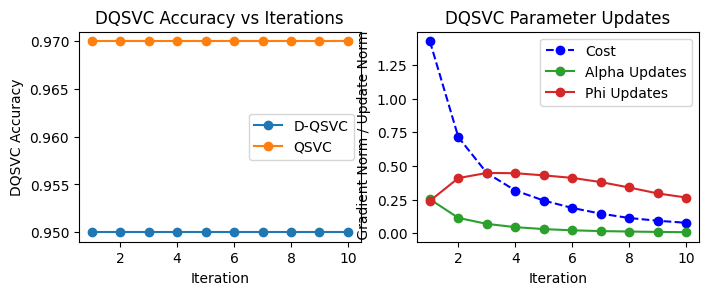

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the cost values over the iterations
plt.figure(figsize=(8, 6))

# Plot classification accuracy over iterations
plt.subplot(2, 2, 1)
qsvc_accuracies = [0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97,0.97, 0.97,0.97]     # QSVC accuracies
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o',  color='#1f77b4', label="D-QSVC")
plt.plot(range(1, len(qsvc_accuracies) + 1), qsvc_accuracies, marker='o', color='#ff7f0e', label="QSVC")
plt.xlabel('Iteration')
plt.ylabel('DQSVC Accuracy')
plt.title('DQSVC Accuracy vs Iterations')
plt.legend()

# Plot gradient norm over iterations
plt.subplot(2, 2, 2)
# Plot gradient norm over iterations
plt.plot(range(1, len(costs) + 1), np.abs(costs), marker='o', label='Cost', color='b',linestyle='--')
# Plot alpha and phi update norms over iterations
plt.plot(range(1, len(alpha_update_norms) + 1), alpha_update_norms, marker='o', label='Alpha Updates', color='#2ca02c')
plt.plot(range(1, len(phi_update_norms) + 1), phi_update_norms, marker='o', label='Phi Updates', color='#d62728')
plt.xlabel('Iteration')
plt.ylabel(' Gradient Norm / Update Norm')
plt.title('DQSVC Parameter Updates')
# Add a legend to differentiate the plots
plt.legend()
plt.savefig('DQSVCIris cost and Parameter Updates.png', dpi=200)
# Display the combined plot
plt.show()


New code

Since FidelityQuantumKernel does not have assign_parameters, we need to update the feature map parameters and then re-create the kernel using the updated feature map.

Removed assign_parameters from quantum_kernel: Instead of modifying the quantum_kernel parameters directly, we re-create the feature map using ZZFeatureMap with the updated parameters, and pass it to the quantum kernel.

Updated the quantum kernel after each parameter update: The quantum kernel is recreated with the updated feature map on each iteration.

Used StatevectorSampler instead of the deprecated Sampler.